In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import specific_humidity_from_dewpoint
from pint import UnitRegistry
ureg = UnitRegistry()
from scipy.stats import sem, t
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind


In [3]:
# Define file paths
file1 = "/home/maione/work_big/propane/analysis/Propane/Processed_data/processed_met_11_23.csv"
file2 = "/home/maione/work_big/propane/analysis/Propane/Processed_data/processed_c3h8.csv"


# Read meteo data, parse 'DATETIME' as datetime, and set as index
df1 = pd.read_csv(file1, parse_dates=['DATETIME'])
df1 = df1.set_index('DATETIME')
df1 = df1.reset_index().rename(columns={'DATETIME': 'datetime'})  # ensure column is named 'datetime'

# Read C3H8, CO, CH4, =3 data, parse 'datetime' as datetime
df2 = pd.read_csv(file2, parse_dates=['datetime'])



# Merge all datasets on 'datetime' using an inner join
merged_df = df1.merge(df2, on='datetime', how='inner') 
               

# Display result
print(merged_df)

                 datetime  wind_speed  temperature  relative_humidity  \
0     2011-01-27 09:00:00       11.50        -7.30              96.05   
1     2011-01-27 11:00:00       12.50        -6.70              96.70   
2     2011-01-27 13:00:00       20.05        -6.55              96.75   
3     2011-01-27 15:00:00       13.45        -6.35              96.45   
4     2011-01-27 17:00:00       34.10        -7.00              96.00   
...                   ...         ...          ...                ...   
35042 2023-12-31 02:00:00        7.33         3.38              86.00   
35043 2023-12-31 04:00:00        8.13         3.32              87.00   
35044 2023-12-31 05:00:00        7.51         3.48              86.00   
35045 2023-12-31 07:00:00        4.39         2.88              90.00   
35046 2023-12-31 08:00:00        3.83         3.12              88.00   

       pressure  C3H8_ppb  
0        781.50   0.67476  
1        781.95   0.71596  
2        781.25   0.72782  
3        78

In [4]:
# Convert 'DATETIME' column to datetime if not already
#merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
# Convert 'date' to datetime and set as index

# helper columns with  hour, month, year
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['date'] = merged_df['datetime'].dt.date
merged_df['month-day'] = merged_df['datetime'].dt.strftime('%m-%d')

merged_df.index.name = 'index'  # Ensure index has a name




In [5]:
# Ensure 'date' is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['season'] = merged_df['month'].apply(get_season)

In [6]:
#dewpoint from T and RH
dewpoint=dewpoint_from_relative_humidity(merged_df["temperature"].values*units.degC, merged_df["relative_humidity"].values*units.percent)
dewpoint

Magnitude,[-7.837421276863495 -7.152030108988072 -6.99573459693687 ... 1.3524827766619296 1.3944508492633645 1.3182653403757172]
Units,degree_Celsius


In [7]:
#Specific humidity from temperature and dewpoint
SH=specific_humidity_from_dewpoint(merged_df["pressure"].values*units.hPa, dewpoint).to('g/kg')
merged_df ["SH"] = SH
merged_df

,datetime,wind_speed,temperature,relative_humidity,pressure,C3H8_ppb,hour,month,year,date,month-day,season,SH
index,,,,,,,,,,,,,
0,2011-01-27 09:00:00,11.50,-7.30,96.05,781.50,0.67476,9,1,2011,2011-01-27,01-27,Winter,2.703698
1,2011-01-27 11:00:00,12.50,-6.70,96.70,781.95,0.71596,11,1,2011,2011-01-27,01-27,Winter,2.849465
2,2011-01-27 13:00:00,20.05,-6.55,96.75,781.25,0.72782,13,1,2011,2011-01-27,01-27,Winter,2.886636
3,2011-01-27 15:00:00,13.45,-6.35,96.45,780.75,0.72500,15,1,2011,2011-01-27,01-27,Winter,2.924111
4,2011-01-27 17:00:00,34.10,-7.00,96.00,780.20,0.74131,17,1,2011,2011-01-27,01-27,Winter,2.770304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35042,2023-12-31 02:00:00,7.33,3.38,86.00,796.79,0.07656,2,12,2023,2023-12-31,12-31,Winter,5.236215
35043,2023-12-31 04:00:00,8.13,3.32,87.00,796.59,0.11815,4,12,2023,2023-12-31,12-31,Winter,5.276174
35044,2023-12-31 05:00:00,7.51,3.48,86.00,796.42,0.10664,5,12,2023,2023-12-31,12-31,Winter,5.275921


In [ ]:
#CHECK for correct indexing of datetime

#merged_df.index = merged_df.datetime
#merged_df.year.plot()

In [8]:
# 1/4
# COUNT OCCURRENCES OF EACH LABEL PER EVENT

# Filter between dates (inclusive)
start_date = '2022/01/01'
end_date = '2022/12/31'
filtered_df = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

print(filtered_df)

                 datetime  wind_speed  temperature  relative_humidity  \
index                                                                   
28714 2022-02-17 23:00:00       13.64         -2.8               98.0   
28715 2022-02-18 00:00:00       10.82         -2.7               98.0   
28716 2022-02-18 02:00:00       11.79         -2.6               98.0   
28717 2022-02-18 03:00:00       10.57         -2.4               98.0   
28718 2022-02-18 05:00:00       10.64         -2.9               95.0   
...                   ...         ...          ...                ...   
31668 2022-12-28 19:00:00        4.99          2.2               65.0   
31669 2022-12-29 00:00:00        6.79          2.3               76.0   
31670 2022-12-29 01:00:00        4.10          2.4               76.0   
31671 2022-12-29 03:00:00        5.61          3.2               75.0   
31672 2022-12-29 04:00:00        6.11          2.8               79.0   

       pressure  C3H8_ppb  hour  month  year      

In [9]:
## 2/4
# COUNT OCCURRENCES OF EACH LABEL PER EVENT
#  Compute 25th and 75th percentiles for SH and WS over the whole dataset
sh_25, sh_75 = filtered_df["SH"].quantile(0.25), filtered_df["SH"].quantile(0.75)
ws_25, ws_75 = filtered_df["wind_speed"].quantile(0.25), filtered_df["wind_speed"].quantile(0.75)

# Assign computed quantiles as new columns
filtered_df["SH_25"], filtered_df["SH_75"] = sh_25, sh_75
filtered_df["WS_25"], filtered_df["WS_75"] = ws_25, ws_75

filt_df_percentile=filtered_df
# Print  rows to check
#print(filt_df_percentile.tail())

/tmp/ipykernel_1620268/4170028387.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["SH_25"], filtered_df["SH_75"] = sh_25, sh_75
/tmp/ipykernel_1620268/4170028387.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["SH_25"], filtered_df["SH_75"] = sh_25, sh_75
/tmp/ipykernel_1620268/4170028387.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [10]:
## 3/4
# COUNT OCCURRENCES OF EACH LABEL PER EVENT
# Apply conditions to classify data
def classify(row):
    if row["SH"] < row["SH_25"] and row["wind_speed"] > row["WS_25"]:
        return "FT"
    elif row["SH"] > row["SH_75"] and row["wind_speed"] < row["WS_25"]:
        return "PBL"
    else:
        return "Other"

filt_df_percentile["Label"] = filt_df_percentile.apply(classify, axis=1)

/tmp/ipykernel_1620268/1153242399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df_percentile["Label"] = filt_df_percentile.apply(classify, axis=1)


In [12]:
filt_df_percentile

,datetime,wind_speed,temperature,relative_humidity,pressure,C3H8_ppb,hour,month,year,date,month-day,season,SH,SH_25,SH_75,WS_25,WS_75,Label
index,,,,,,,,,,,,,,,,,,
28714,2022-02-17 23:00:00,13.64,-2.8,98.0,787.0,0.34522,23,2,2022,2022-02-17,02-17,Winter,3.856071,3.300732,6.065003,3.06,7.42,Other
28715,2022-02-18 00:00:00,10.82,-2.7,98.0,787.0,0.32936,0,2,2022,2022-02-18,02-18,Winter,3.884925,3.300732,6.065003,3.06,7.42,Other
28716,2022-02-18 02:00:00,11.79,-2.6,98.0,787.1,0.28115,2,2,2022,2022-02-18,02-18,Winter,3.913472,3.300732,6.065003,3.06,7.42,Other
28717,2022-02-18 03:00:00,10.57,-2.4,98.0,787.1,0.27996,3,2,2022,2022-02-18,02-18,Winter,3.972137,3.300732,6.065003,3.06,7.42,Other
28718,2022-02-18 05:00:00,10.64,-2.9,95.0,786.9,0.25747,5,2,2022,2022-02-18,02-18,Winter,3.710341,3.300732,6.065003,3.06,7.42,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31668,2022-12-28 19:00:00,4.99,2.2,65.0,780.4,0.57800,19,12,2022,2022-12-28,12-28,Winter,3.711469,3.300732,6.065003,3.06,7.42,Other
31669,2022-12-29 00:00:00,6.79,2.3,76.0,781.9,0.34630,0,12,2022,2022-12-29,12-29,Winter,4.364618,3.300732,6.065003,3.06,7.42,Other
31670,2022-12-29 01:00:00,4.10,2.4,76.0,782.5,0.32945,1,12,2022,2022-12-29,12-29,Winter,4.392552,3.300732,6.065003,3.06,7.42,Other


In [21]:
df_pbl_era = pd.read_csv("/home/maione/work_big/propane/analysis/Propane/BLH_ERA5/ft_df_2022.csv",sep=',')
df_pbl_era.rename(columns={'time': 'datetime'}, inplace=True)
df_pbl_era

,datetime,FT
0,2022-01-01 00:00:00,True
1,2022-01-01 01:00:00,True
2,2022-01-01 02:00:00,True
3,2022-01-01 03:00:00,True
4,2022-01-01 04:00:00,True
...,...,...
8755,2022-12-31 19:00:00,True
8756,2022-12-31 20:00:00,True
8757,2022-12-31 21:00:00,True
8758,2022-12-31 22:00:00,True


In [17]:
df_era_22= filt_df_percentile[['datetime','Label']].reset_index(drop=True)
df_era_22

,datetime,Label
0,2022-02-17 23:00:00,Other
1,2022-02-18 00:00:00,Other
2,2022-02-18 02:00:00,Other
3,2022-02-18 03:00:00,Other
4,2022-02-18 05:00:00,Other
...,...,...
2954,2022-12-28 19:00:00,Other
2955,2022-12-29 00:00:00,Other
2956,2022-12-29 01:00:00,Other
2957,2022-12-29 03:00:00,Other


In [27]:
df_era_22['datetime'] = pd.to_datetime(df_era_22['datetime'])
df_pbl_era['datetime'] = pd.to_datetime(df_pbl_era['datetime'])
df_merge = pd.merge(df_era_22, df_pbl_era, on='datetime', how='outer')
df_merge.dropna(inplace=True)
df_merge.drop(df_merge[df_merge['Label'] == 'Other'].index, inplace=True)  # Remove 'Other' labels
df_merge

,datetime,Label,FT
1182,2022-02-19 06:00:00,FT,True
1184,2022-02-19 08:00:00,FT,True
1185,2022-02-19 09:00:00,FT,True
1187,2022-02-19 11:00:00,FT,True
1188,2022-02-19 12:00:00,FT,True
...,...,...,...
8536,2022-12-22 11:00:00,FT,True
8681,2022-12-28 12:00:00,FT,True
8682,2022-12-28 13:00:00,FT,True
8684,2022-12-28 15:00:00,FT,True


In [28]:
def calculate_score(df):
    """
    Calculates a score where:
    - 1 point for each correct FT (Label=FT and FT=True)
    - 1 point for each correct PBL (Label=PBL and FT=False)
    - 0 points for Other labels or incorrect matches
    Returns the score and total possible points
    """
    # Count good matches
    correct_ft = ((df['Label'] == 'FT') & (df['FT'] == True)).sum()
    correct_pbl = ((df['Label'] == 'PBL') & (df['FT'] == False)).sum()
    
    # Calculate totals
    total_possible = (df['Label'].isin(['FT', 'PBL'])).sum()
    score = correct_ft + correct_pbl
    
    return score, total_possible

# Example usage:
score, total = calculate_score(df_merge)
print(f"Score: {score}/{total} ({score/total:.1%} accuracy for FT/PBL classification)")

Score: 613/917 (66.8% accuracy for FT/PBL classification)


In [32]:
# Add a scoring column
df_merge['Score'] = 0
df_merge.loc[(df_merge['Label'] == 'FT') & (df_merge['FT']), 'Score'] = 1
df_merge.loc[(df_merge['Label'] == 'PBL') & (~df_merge['FT']), 'Score'] = 1

# Calculate totals
total_ft_pbl = df_merge['Label'].isin(['FT', 'PBL']).sum()
accuracy = df_merge['Score'].sum() / total_ft_pbl
print(f"Classification Accuracy: {accuracy:.1%}")

Classification Accuracy: 66.8%


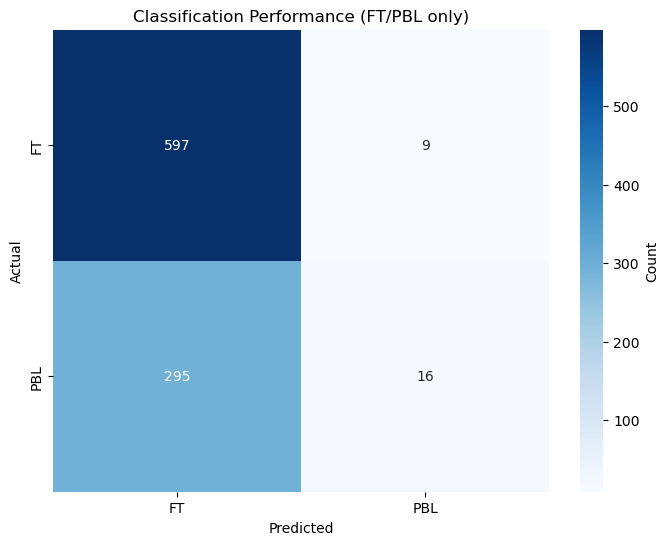

In [36]:
confusion_df = df_merge[df_merge['Label'].isin(['FT', 'PBL'])].copy()
confusion_df['Predicted'] = confusion_df['FT'].map({True: 'FT', False: 'PBL'})

plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(confusion_df['Label'], confusion_df['Predicted']), 
            annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'})
plt.title('Classification Performance (FT/PBL only)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
### 4/4
# COUNT OCCURRENCES OF EACH LABEL PER EVENT
#  Count occurrences of each label per event
event_counts = filt_df_percentile.groupby(["datetime"])["Label"].value_counts().unstack(fill_value=0)
# Count occurrences of 'pbl' and 'ft'
count_pbl = (filt_df_percentile["Label"] == 'PBL').sum()
count_ft = (filt_df_percentile["Label"] == 'FT').sum()
count_Other = (filt_df_percentile["Label"] == 'Other').sum()

print(f"Count of 'pbl': {count_pbl}")
print(f"Count of 'ft': {count_ft}")
print(f"Count of 'Other': {count_Other}")
count_event= count_ft + count_pbl+ count_Other
event_perc = (event_counts.div(count_event, axis=0)) * 100


Count of 'pbl': 311
Count of 'ft': 606
Count of 'Other': 2042


In [ ]:


# Filter data from 2015 to 2019
df_15_19 = df[(df["year"] >= 2015) & (df["year"] <= 2019)]

df_15_19


In [ ]:
# Compute 25th and 75th percentiles for SH and WS over the whole dataset
sh_25, sh_75 = merged_df["SH"].quantile(0.25), merged_df["SH"].quantile(0.75)
ws_25, ws_75 = merged_df["wind_speed"].quantile(0.25), merged_df["wind_speed"].quantile(0.75)

# Assign computed quantiles as new columns
merged_df["SH_25"], merged_df["SH_75"] = sh_25, sh_75
merged_df["WS_25"], merged_df["WS_75"] = ws_25, ws_75

df_percentile=merged_df
# Print  rows to check
print(df_percentile.tail())


In [ ]:
df_15_19.temperature.plot()

In [ ]:


# Apply conditions to classify data
def classify(row):
    if row["SH"] < row["SH_25"] and row["wind_speed"] > row["WS_25"]:
        return "FT"
    elif row["SH"] > row["SH_75"] and row["wind_speed"] < row["WS_25"]:
        return "PBL"
    else:
        return "Other"

df_percentile["Label"] = df_percentile.apply(classify, axis=1)



In [ ]:
monthly_stats = df_percentile.groupby(["month"])["Label"].describe()
monthly_stats

In [ ]:
# Count occurrences of each label per month
#monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
#monthly_total = monthly_counts.sum(axis=1)
#entry_count = df_percentile["Label"].count()
# Convert FT and PBL counts to percentages
#monthly_percentage = (monthly_counts.div(entry_count, axis=0)) * 100

In [ ]:
# Count occurrences of each label per month
monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
# Count occurrences of 'pbl' and 'ft'
count_pbl = (df_percentile["Label"] == 'PBL').sum()
count_ft = (df_percentile["Label"] == 'FT').sum()

print(f"Count of 'pbl': {count_pbl}")
print(f"Count of 'ft': {count_ft}")
count_ft_pbl= count_ft + count_pbl
monthly_percentage = (monthly_counts.div(count_ft_pbl, axis=0)) * 100

In [ ]:
monthly_counts

In [ ]:
monthly_percentage

In [ ]:
#ft_count = (df_percentile["Label"] == 'FT').sum()
#ft_perc=(ft_count /entry_count )*100
#print(ft_perc)


In [ ]:
ft_count = (df_percentile["Label"] == 'FT').sum()
ft_perc=(ft_count /count_ft_pbl )*100
print(ft_perc)

In [ ]:
#pbl_count = (df_percentile["Label"] == 'PBL').sum()
#pbl_perc=(pbl_count /entry_count )*100
#print(pbl_perc)


In [ ]:
pbl_count = (df_percentile["Label"] == 'PBL').sum()
pbl_perc=(pbl_count /count_ft_pbl)*100
print(pbl_perc)


In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_percentage.index, monthly_percentage["FT"], marker="o", linestyle="-", label="FT Frequency", color="red")
plt.plot(monthly_percentage.index, monthly_percentage["PBL"], marker="s", linestyle="--", label="PBL Frequency", color="blue")

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Frequency [%]")
#plt.title("Monthly Frequency of FT and PBL Observations (2011-2023)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.ylim(0,25)
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\meteo_FT_PBL_11_23.png", dpi=300)

# Show plot
plt.show()


In [ ]:
monthly_percentage["PBL"]

In [ ]:
monthly_percentage["FT"]

In [ ]:

# Define date ranges
date_ranges = {
    "03-09 to 05-04": ("03-09", "05-04"),
    "05-05 to 10-22": ("05-05", "10-22"),
    "10-23 to 12-29": ("10-23", "12-29"),
}

In [ ]:



results = []

# Loop by Label and date range
for label in merged_df['Label'].unique():
    for range_name, (start_md, end_md) in date_ranges.items():
        # Filter current label and date range
        mask = (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        subset = merged_df[mask & (merged_df['Label'] == label)]

        # Mean C3H8_ppb for each period
        mean_2020 = subset[subset['year'] == 2020]['C3H8_ppb'].mean()
        mean_2017_2019 = subset[subset['year'].isin([2017, 2018, 2019])]['C3H8_ppb'].mean()
        mean_2021_2023 = subset[subset['year'].isin([2021, 2022, 2023])]['C3H8_ppb'].mean()

        # Differences
        diff_2020_2017_2019 = mean_2020 - mean_2017_2019
        diff_2020_2021_2023 = mean_2020 - mean_2021_2023

        # Append results
        results.append({
            'Label': label,
            'Date Range': range_name,
            '2020 Mean': mean_2020,
            '2017–2019 Mean': mean_2017_2019,
            '2021–2023 Mean': mean_2021_2023,
            'Diff (2020 - 2017–2019)': diff_2020_2017_2019,
            'Diff (2020 - 2021–2023)': diff_2020_2021_2023
        })

# Create DataFrame
diff_df = pd.DataFrame(results)
print(diff_df)
diff_df.to_csv("C:\\YEAR1\\NMVOC\\figures\\Covid_FT_PBL.csv")



In [ ]:
#To calculate whether the differences in C3H8_ppb means in 2020 vs. 2017–2019 and 2021–2023 
# are statistically significant at the 95% confidence level (p < 0.05
 #Welch's t-test (scipy.stats.ttest_ind



results = []

# Loop through each label and date range
for label in merged_df['Label'].unique():
    for range_name, (start_md, end_md) in date_ranges.items():
        # Filter by label and date range
        mask = (merged_df['Label'] == label) & (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        subset = merged_df[mask]

        # Get groups
        c3h8_2020 = subset[subset['year'] == 2020]['C3H8_ppb']
        c3h8_2017_2019 = subset[subset['year'].isin([2017, 2018, 2019])]['C3H8_ppb']
        c3h8_2021_2023 = subset[subset['year'].isin([2021, 2022, 2023])]['C3H8_ppb']

        # Means
        mean_2020 = c3h8_2020.mean()
        mean_17_19 = c3h8_2017_2019.mean()
        mean_21_23 = c3h8_2021_2023.mean()

        # T-tests (Welch's)
        t_stat1, pval1 = stats.ttest_ind(c3h8_2020, c3h8_2017_2019, equal_var=False, nan_policy='omit')
        t_stat2, pval2 = stats.ttest_ind(c3h8_2020, c3h8_2021_2023, equal_var=False, nan_policy='omit')

        results.append({
            'Label': label,
            'Date Range': range_name,
            '2020 Mean': mean_2020,
            '2017–2019 Mean': mean_17_19,
            '2021–2023 Mean': mean_21_23,
            'p-value (2020 vs 2017–2019)': pval1,
            'Significant (p<0.05)': pval1 < 0.05,
            'p-value (2020 vs 2021–2023)': pval2,
            'Significant (p<0.05)': pval2 < 0.05,
        })

# Create DataFrame
Covid_df = pd.DataFrame(results)
print(Covid_df)
Covid_df.to_csv("C:\\YEAR1\\NMVOC\\figures\\Covid_FT_PBL.csv",sep="\t")
